## Setups

In [6]:
import psycopg2
import pandas as pd
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import string
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import pickle
import tqdm
from sklearn.linear_model import LogisticRegression
#from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

wordnet_lemmatizer = WordNetLemmatizer()
dbname = 'bills_db'
username = 'joeljoel'

In [7]:
import os
import yaml
import sys

os.chdir('..')

In [8]:
from src.ingest.get_bills import get_us_bills
from src.ingest.get_bills import get_ny_bills
from src.ingest.get_bills import get_subjects
from src.wrangle.create_features import make_feat_union
from src.analyze.run_model import create_model
from src.analyze.run_model import run_model
from src.wrangle.create_features import make_x_values
from src.wrangle.create_features import make_y_values
from src.wrangle.create_features import lemmatize_tokens
from src.wrangle.create_features import tokenize
from src.wrangle.create_features import my_preproc_text
from src.wrangle.create_features import my_preproc_title
from src.analyze.run_model import get_y_probs
from src.report.store_db import store_us_db
from src.report.store_db import store_ny_db
from src.report.make_roc_curve import make_roc_curve
from src.utils.get_time_stamp import get_time_stamp

ModuleNotFoundError: No module named 'sklearn.grid_search'

In [9]:
con = psycopg2.connect(database = dbname, user = username)

#### Rerun only if the underlying data has changed

#### query:
sql_query = """
SELECT * FROM us_bills;
"""
us_bills = pd.read_sql_query(sql_query,con)
us_X = make_x_values(us_bills)
us_tf_vect_raw = CountVectorizer(stop_words='english', tokenizer=tokenize, preprocessor=my_preproc_text)
us_tf_text_raw = us_tf_vect_raw.fit_transform(us_X)
us_tf_vect_clean = CountVectorizer(stop_words='english', tokenizer=tokenize, preprocessor=my_preproc_text,  
                                   min_df=10, max_df=0.4)
us_tf_text_clean = us_tf_vect_clean.fit_transform(us_X)
pickle.dump((us_bills, us_X), open('../presentations/data/us_data.p', 'wb'))
pickle.dump((us_tf_vect_raw, us_tf_text_raw, us_tf_vect_clean, us_tf_text_clean), 
            open('../presentations/data/us_tf.p', 'wb'))

#### Rerun only if the underlying data has changed

con = psycopg2.connect(database = dbname, user = username)

#### query:
sql_query = """
SELECT * FROM ny_bills;
"""
ny_bills = pd.read_sql_query(sql_query,con)
ny_X = make_x_values(ny_bills)
ny_tf_vect_raw = CountVectorizer(stop_words='english', tokenizer=tokenize, preprocessor=my_preproc_text)
ny_tf_text_raw = ny_tf_vect_raw.fit_transform(ny_X)
ny_tf_vect_clean = CountVectorizer(stop_words='english', tokenizer=tokenize, preprocessor=my_preproc_text,  
                                   min_df=10, max_df=0.4)
ny_tf_text_clean = ny_tf_vect_clean.fit_transform(ny_X)
pickle.dump((ny_bills, ny_X), open('../presentations/data/ny_data.p', 'wb'))
pickle.dump((ny_tf_vect_raw, ny_tf_text_raw, ny_tf_vect_clean, ny_tf_text_clean), 
            open('../presentations/data/ny_tf.p', 'wb'))

In [10]:
us_bills, us_x = pickle.load(open('/Users/joeljoel/Google Drive/presentations/data/us_data.p', 'rb'))
us_tf_vect_raw, us_tf_text_raw, us_tf_vect_clean, us_tf_text_clean = pickle.load(
    open('../presentations/data/us_tf.p', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '../presentations/data/us_data.p'

In [5]:
ny_bills, ny_x = pickle.load(open('../presentations/data/ny_data.p', 'rb'))
ny_tf_vect_raw, ny_tf_text_raw, ny_tf_vect_clean, ny_tf_text_clean = pickle.load(
    open('../presentations/data/ny_tf.p', 'rb'))

## Slide 4

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### here we set some aesthetic parameters so that all of our figures are nice and big
plt.rcParams['figure.figsize'] = (3, 8)
plt.rcParams['font.size'] = 20
sns.set(style="white", context="talk")

In [82]:
#plt.rcParams.keys()

In [17]:
column_sums = us_tf_text_raw.sum(axis=0)

In [137]:
label_size = 11
figsize = (10, 3)

In [18]:
sum_df = pd.DataFrame(column_sums.transpose(), index=us_tf_vect_raw.get_feature_names(), columns=['word_counts'])

In [50]:
us_top_20 = sum_df.sort_values(by='word_counts', ascending=False)[0:20]

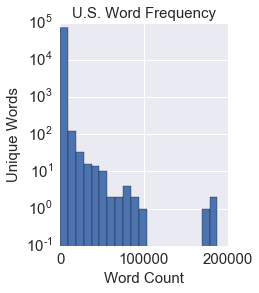

In [39]:
plt.figure(figsize=(3,4))
plt.hist(sum_df['word_counts'], 20, log=True)
plt.ylabel("Unique Words", size=15)
plt.xlabel("Word Count", size=15)
plt.ylim(0.1)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("U.S. Word Frequency", size=15)
plt.locator_params(axis='x', nbins=3)

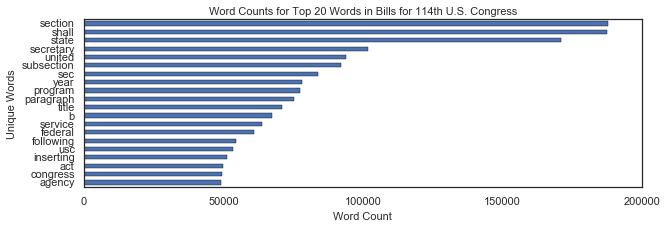

In [269]:
us_top_20.sort_values(by='word_counts').plot(kind='barh', legend=None, figsize=figsize)
plt.ylabel("Unique Words", size=label_size)
plt.xlabel("Word Count", size=label_size)
plt.yticks(size=label_size)
plt.xticks(size=label_size)
plt.title("Word Counts for Top 20 Words in Bills for 114th U.S. Congress", size=label_size)

#### To build a word cloud
all_words = [word for word in tqdm.tqdm(vect.get_feature_names()) for i in range(0,sum_df.ix[word,0])]
one_text = " ".join(all_words)
wordcloud = WordCloud().generate(one_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [24]:
ny_column_sums = ny_tf_text_raw.sum(axis=0)

In [25]:
ny_sum_df = pd.DataFrame(ny_column_sums.transpose(), index=ny_tf_vect_raw.get_feature_names(), columns=['word_counts'])

In [34]:
ny_top_20 = ny_sum_df.sort_values(by='word_counts', ascending=False)[0:20]

plt.hist(ny_sum_df['word_counts'], 50, log=True)
plt.ylabel("Number of Unique Words with Given Word Count")
plt.xlabel("Word Count of Unique Words")
plt.ylim(0.1)
plt.title("Histogram of Word Frequency in Bills for 2015 Session of New York Legislature")

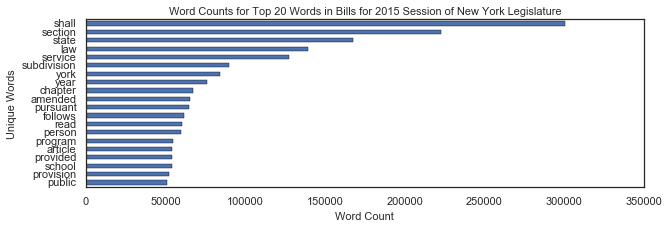

In [270]:
ny_top_20.sort_values(by='word_counts').plot(kind='barh', legend=None, figsize=figsize)
plt.ylabel("Unique Words", size=label_size)
plt.xlabel("Word Count", size=label_size)
plt.yticks(size=label_size)
plt.xticks(size=label_size)
plt.title("Word Counts for Top 20 Words in Bills for 2015 Session of New York Legislature", size=label_size)

ny_all_words = [word for word in tqdm.tqdm(ny_vect.get_feature_names()) for i in range(0,ny_sum_df.ix[word,0])]
ny_one_text = " ".join(ny_all_words)
wordcloud = WordCloud().generate(ny_one_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Slide 5

### Cleaned by focusing only on words in at least 10 documents and fewer than 40% of documents

In [40]:
us_clean_column_sums = us_tf_text_clean.sum(axis=0)

In [41]:
us_clean_sum_df = pd.DataFrame(us_clean_column_sums.transpose(), index=us_tf_vect_clean.get_feature_names(), columns=['word_counts'])

In [121]:
us_clean_top_20 = us_clean_sum_df.sort_values(by='word_counts', ascending=False)[0:20]

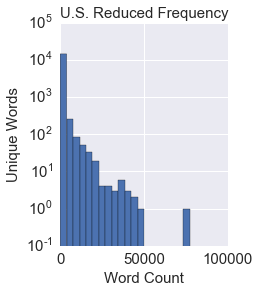

In [58]:
plt.figure(figsize=(3,4))
plt.hist(us_clean_sum_df['word_counts'], 20, log=True)
plt.ylabel("Unique Words", size=15)
plt.xlabel("Word Count", size=15)
plt.ylim(0.1)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("U.S. Reduced Frequency", size=15)
plt.locator_params(axis='x', nbins=3)


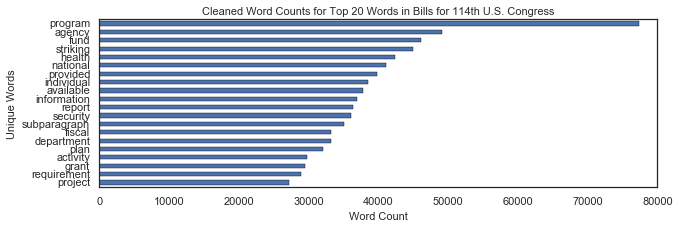

In [271]:
us_clean_top_20.sort_values(by='word_counts').plot(kind='barh', legend=None, figsize=figsize)
plt.ylabel("Unique Words", size=label_size)
plt.xlabel("Word Count", size=label_size)
plt.yticks(size=label_size)
plt.xticks(size=label_size)
plt.title("Cleaned Word Counts for Top 20 Words in Bills for 114th U.S. Congress", size=label_size)

us_clean_all_words = [word for word in tqdm.tqdm(us_clean_vect.get_feature_names()) for i in range(0,us_clean_sum_df.ix[word,0])]
us_clean_one_text = " ".join(us_clean_all_words)
wordcloud = WordCloud().generate(us_clean_one_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### NY Clean Data

In [125]:
ny_clean_column_sums = ny_tf_text_clean.sum(axis=0)

In [126]:
ny_clean_sum_df = pd.DataFrame(ny_clean_column_sums.transpose(), index=ny_tf_vect_clean.get_feature_names(), columns=['word_counts'])

In [127]:
ny_clean_top_20 = ny_clean_sum_df.sort_values(by='word_counts', ascending=False)[0:20]

plt.hist(ny_clean_sum_df['word_counts'], 50, log=True)
plt.ylabel("Number of Unique Words with Given Word Count")
plt.xlabel("Word Count of Unique Words")
plt.ylim(0.1)
plt.title("Histogram of Word Frequency in Bills for 114th U.S. Congress")

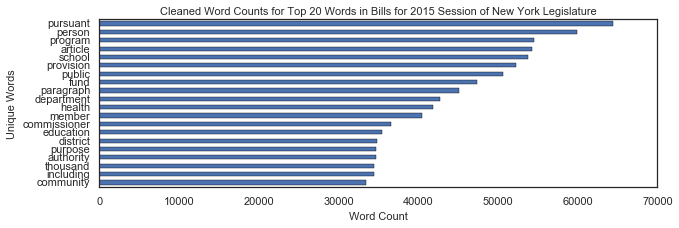

In [272]:
ny_clean_top_20.sort_values(by='word_counts').plot(kind='barh', legend=None, figsize=figsize)
plt.ylabel("Unique Words", size=label_size)
plt.xlabel("Word Count", size=label_size)
plt.yticks(size=label_size)
plt.xticks(size=label_size)
plt.title("Cleaned Word Counts for Top 20 Words in Bills for 2015 Session of New York Legislature", size=label_size)

ny_clean_all_words = [word for word in tqdm.tqdm(ny_clean_vect.get_feature_names()) for i in range(0,ny_clean_sum_df.ix[word,0])]
ny_clean_one_text = " ".join(ny_clean_all_words)
wordcloud = WordCloud().generate(ny_clean_one_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Slide 6

### Build for ROC Curves and Confusion Matrices

In [144]:
con = psycopg2.connect(database = dbname, user = username)
sql_str = """
    SELECT bill_num, subject FROM bill_subject
    WHERE subject='Health'
    """
sub_bills = pd.read_sql_query(sql_str, con)
y_health = make_y_values(us_bills, sub_bills, 'Health')

In [189]:
sql_str = """
    SELECT bill_num, subject FROM bill_subject
    WHERE subject='Intellectual property'
    """
sub_bills = pd.read_sql_query(sql_str, con)
y_ip = make_y_values(us_bills, sub_bills, 'Intellectual property')

In [162]:
lr = LogisticRegression(penalty='l2', C=10)

In [164]:
pipeline = Pipeline(steps=[("tf", us_tf_vect_clean), ('lr', lr)])

In [11]:
ymlfile = open("configs.yml", 'r')
cfg = yaml.load(ymlfile)
ymlfile.close()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ....................................... , score=0.779421 - 5.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:  5.7min


[CV] ....................................... , score=0.714028 - 5.3min
[CV]  ................................................................
[CV] ....................................... , score=0.756213 - 5.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.3min finished


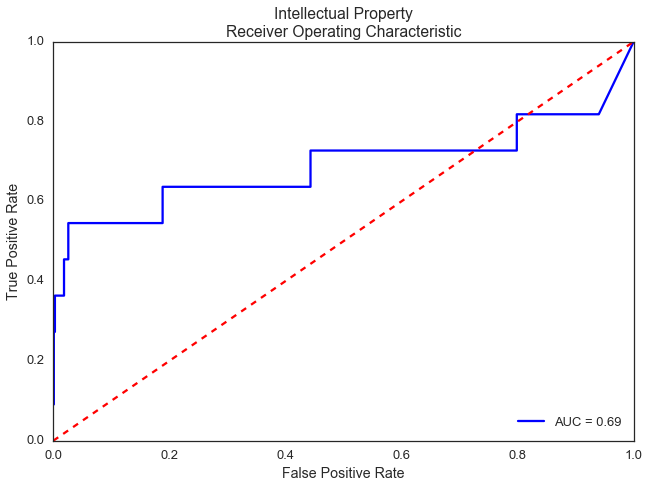

In [191]:
import src.report.make_roc_curve
reload(src.report.make_roc_curve)
make_roc_curve(pipeline, us_x, y_ip, 0.9, 'Intellectual Property', cfg)

In [175]:
results_health = pickle.load(open('../presentations/figures/roc_health_tf_2016-09-24-13-52-01.p', 'rb'))

In [179]:
results_health[4]

array([[953,  11],
       [ 12, 118]])

In [193]:
results_ip = pickle.load(open('../presentations/figures/split_data_intellectual property_2016-09-24-14-49-24.p', 'rb'))

In [194]:
results_ip[4]

array([[1081,    2],
       [   8,    3]])

## Slide 7

### Produce density plots for TF-IDF

We would need to get count vectors for each of the words

us_tfidf_vect = TfidfVectorizer(stop_words='english', tokenizer=tokenize, preprocessor=my_preproc_text,  min_df=10, max_df=0.4)
us_tfidf_text = us_tfidf_vect.fit_transform(us_x)
pickle.dump((us_tfidf_vect, us_tfidf_text), open('../presentations/data/us_tfidf.p', 'wb'))

ny_tfidf_vect = TfidfVectorizer(stop_words='english', tokenizer=tokenize, preprocessor=my_preproc_text,  min_df=10, max_df=0.4)
ny_tfidf_text = ny_tfidf_vect.fit_transform(ny_x)
pickle.dump((ny_tfidf_vect, ny_tfidf_text), open('../presentations/data/ny_tfidf.p', 'wb'))

In [63]:
us_tfidf_vect, us_tfidf_text = pickle.load(open('../presentations/data/us_tfidf.p', 'rb'))

In [200]:
ny_tfidf_vect, ny_tfidf_text = pickle.load(open('../presentations/data/ny_tfidf.p', 'rb'))

In [64]:
tfidf_us_column_sums = us_tfidf_text.sum(axis=0)

In [65]:
tfidf_us_sum_df = pd.DataFrame(tfidf_us_column_sums.transpose(), index=us_tfidf_vect.get_feature_names(), columns=['word_counts'])

In [204]:
tfidf_us_top_20 = tfidf_us_sum_df.sort_values(by='word_counts', ascending=False)[0:20]

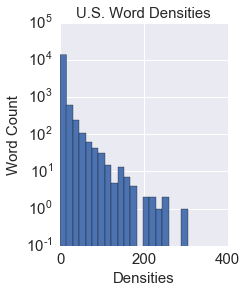

In [69]:
plt.figure(figsize=(3,4))
plt.hist(tfidf_us_sum_df['word_counts'], 20, log=True)
plt.ylabel("Word Count", size=15)
plt.xlabel("Densities", size=15)
plt.ylim(0.1)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("U.S. Word Densities", size=15)
plt.locator_params(axis='x', nbins=3)

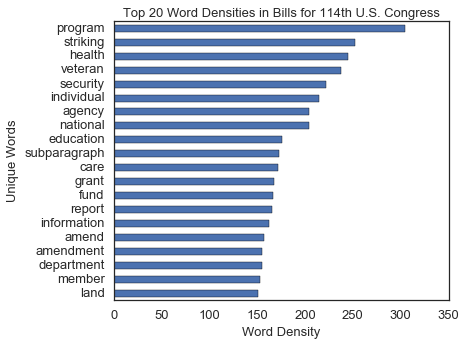

In [274]:
tfidf_us_top_20.sort_values(by='word_counts').plot(kind='barh', legend=None, figsize=(6,5))
plt.ylabel("Unique Words", size=label_size+2)
plt.xlabel("Word Density", size=label_size+2)
plt.yticks(size=label_size+2)
plt.xticks(size=label_size+2)
plt.title("Top 20 Word Densities in Bills for 114th U.S. Congress", size=label_size+2)

In [209]:
tfidf_ny_column_sums = ny_tfidf_text.sum(axis=0)

In [210]:
tfidf_ny_sum_df = pd.DataFrame(tfidf_ny_column_sums.transpose(), index=ny_tfidf_vect.get_feature_names(), columns=['word_counts'])

In [211]:
tfidf_ny_top_20 = tfidf_ny_sum_df.sort_values(by='word_counts', ascending=False)[0:20]

plt.hist(tfidf_ny_sum_df['word_counts'], 50, log=True)
plt.ylabel("Count of Words with Given Density")
plt.xlabel("Densities of Unique Words")
plt.ylim(0.1)
plt.title("Histogram of Word Densities in Bills for 2015 Session of New York Legislature")

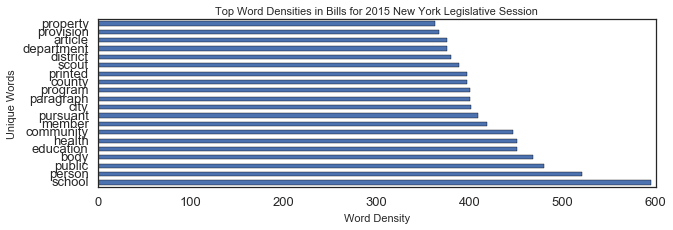

In [275]:
tfidf_ny_top_20.plot(kind='barh', legend=None, figsize=figsize)
plt.ylabel("Unique Words", size=label_size)
plt.xlabel("Word Density", size=label_size)
plt.title("Top Word Densities in Bills for 2015 New York Legislative Session", size=label_size)

import numpy as np
import matplotlib.pyplot as plt

N = 10
data = np.random.random((N, 4))
labels = ['point{0}'.format(i) for i in range(N)]
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, 0], data[:, 1], marker = 'o', c = data[:, 2], s = data[:, 3]*1500,
    cmap = plt.get_cmap('Spectral'))
for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

tfidf_ny_top_10 = tfidf_ny_sum_df.sort_values(by='word_counts', ascending=False)[0:10]

ny_tfs = ny_clean_sum_df[ny_clean_sum_df.index.isin(tfidf_ny_top_10.index)]

ny_idfs = tfidf_ny_top_10/ny_tfs

labels = ny_tfs.sort_index().index
#plt.subplots_adjust(bottom = 0.1)
y = ny_tfs.sort_index()['word_counts']
x = ny_idfs.sort_index()['word_counts']
plt.scatter(
    x, y, marker = 'o', s = tfidf_ny_top_10.sort_index()['word_counts']*0.5,
    c = tfidf_ny_top_10.sort_index()['word_counts'], cmap = plt.get_cmap('Spectral_r'))
for label, x, y in zip(labels, x, y):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-40, 40),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.xlim(0.005,0.02)
plt.show()

## Slide 9

In [227]:
tfidf_health = pickle.load(open('/Users/Joel/Desktop/Insight/bill_taxonomy/models/model_Health_2016-09-23-13-22-32.p'))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ....................................... , score=0.991740 - 6.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:  6.8min


[CV] ....................................... , score=0.995623 - 6.6min
[CV]  ................................................................
[CV] ....................................... , score=0.994079 - 6.8min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.3min finished


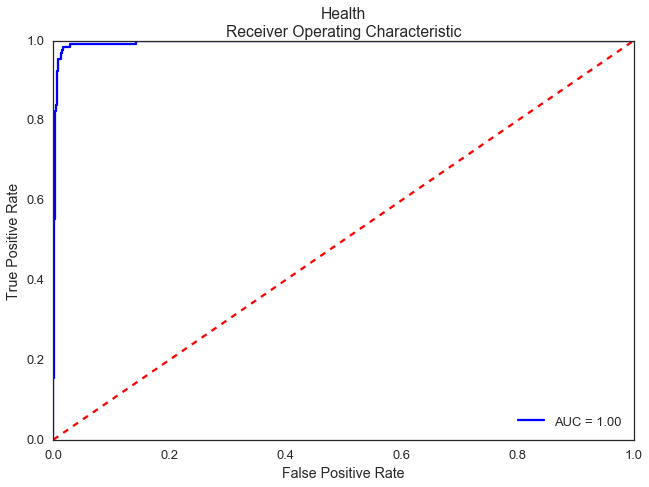

In [229]:
make_roc_curve(tfidf_health.best_estimator_, us_x, y_health, 0.9, 'Health', cfg)

In [230]:
final_health = pickle.load(open('../presentations/figures/split_data_health_2016-09-24-16-25-03.p'))

In [231]:
final_health[4]

array([[956,   8],
       [  7, 123]])

In [75]:
tfidf_ip = pickle.load(open('/Users/Joel/Desktop/Insight/bill_taxonomy/models/presentation_models/model_Intellectual property_2016-09-23-15-07-14.p'))

In [76]:
tfidf_ip.best_score_

0.92719128955081787

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ....................................... , score=0.909898 - 6.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:  6.4min


[CV] ....................................... , score=0.893899 - 6.6min
[CV]  ................................................................
[CV] ....................................... , score=0.952397 - 6.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.4min finished


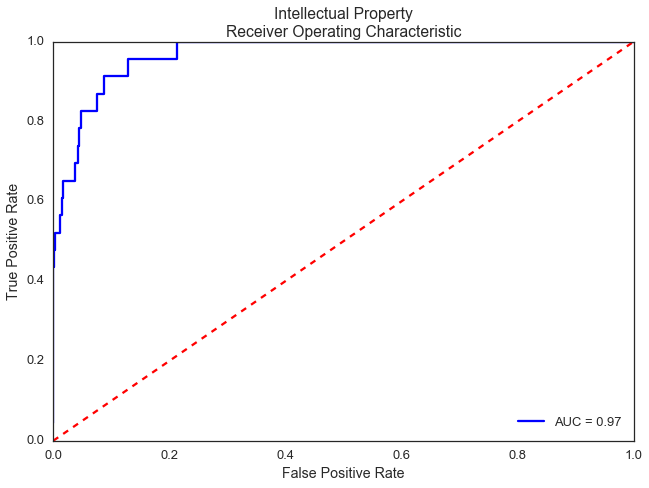

In [234]:
make_roc_curve(tfidf_ip.best_estimator_, us_x, y_ip, 0.8, 'Intellectual Property', cfg)

In [71]:
final_ip = pickle.load(open('../presentations/figures/split_data_intellectual property_2016-09-24-17-00-41.p'))

In [236]:
final_ip[4]

array([[2164,    0],
       [  13,   10]])

In [4]:
final_tax = pickle.load(open('models/model_Taxation_2016-09-26-08-30-51.p'))

In [6]:
final_tax.best_params_

{'features__tfidf_text__max_df': 0.4,
 'features__tfidf_text__max_features': None,
 'features__tfidf_text__min_df': 10,
 'features__tfidf_text__ngram_range': (1, 2),
 'features__tfidf_title__max_df': 0.4,
 'features__tfidf_title__max_features': None,
 'features__tfidf_title__min_df': 10,
 'features__tfidf_title__ngram_range': (1, 3),
 'model__C': 1,
 'model__penalty': 'l2'}

In [10]:
sql_str = """
    SELECT bill_num, subject FROM bill_subject
    WHERE subject='Taxation'
    """
sub_bills = pd.read_sql_query(sql_str, con)
y_tax = make_y_values(us_bills, sub_bills, 'Taxation')

In [12]:
make_roc_curve(final_tax.best_estimator_, us_x, y_tax, 0.8, 'Taxation', cfg)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ....................................... , score=0.997176 - 5.9min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:  5.9min


[CV] ....................................... , score=0.997051 - 5.7min
[CV]  ................................................................
[CV] ....................................... , score=0.997677 - 5.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.4min finished


0.989940557842
[[1995    4]
 [  18  170]]


In [14]:
subject = "Bank accounts, deposits, capital"

if (subject.split(' ')[0] == 'Bank'):
    subject = subject.replace('capital', 'and capital')
subject = subject.replace(' ', '_')
subject = subject.replace(',', '')

print subject

Bank_accounts_deposits_and_capital


## Slide 10

In [77]:
best_est_lr = tfidf_ip.best_estimator_.steps[1][1]

In [82]:
feats = tfidf_ip.best_estimator_.steps[0][1]

In [83]:
feat_names = feats.get_feature_names()

In [84]:
weights = [(feat_names[i], best_est_lr.coef_[0][i]) for i in tqdm.tqdm(range(0, len(best_est_lr.coef_[0])))]

100%|██████████| 121433/121433 [00:00<00:00, 276177.40it/s]


In [90]:
sort_weights = sorted(weights, key=lambda (a,b): abs(b), reverse=True)[0:10]

In [93]:
# Don't think I need this anymore but afraid to get rid of it
# feat_vect = [s[0].split('_')[1] + ': ' + s[1] for s in top20_df['feature'].str.split('__')]

In [91]:
top10_df = pd.DataFrame(sort_weights, columns=['feature', 'coefficient'])
feat_vect = [s[0].split('_')[1] + ': ' + s[1] for s in top10_df['feature'].str.split('__')]
top10_df.ix[:, 'feature'] = feat_vect
top10_df.set_index('feature', inplace=True)

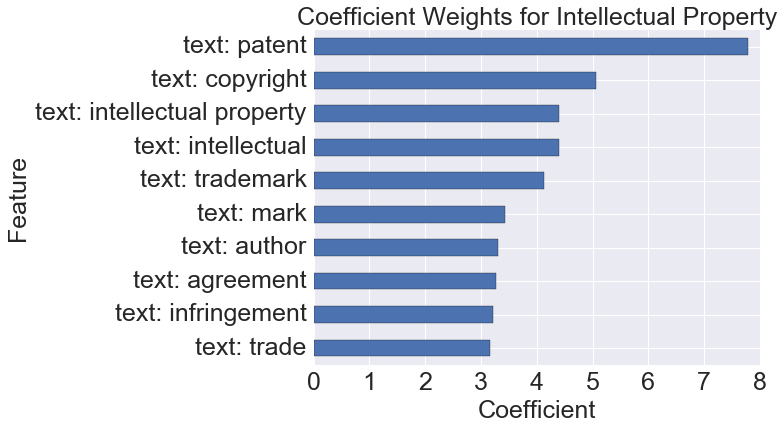

In [101]:
top10_df.sort_values(by='coefficient').plot(kind='barh', legend=None, figsize=(8,6))
plt.ylabel("Feature", size=25)
plt.xlabel("Coefficient", size=25)
plt.xticks(size=25)
plt.yticks(size=25)
plt.title("Coefficient Weights for Intellectual Property", size=25)

## Notes from the production of Slide 8

In [ ]:
svc_model = pickle.load(open('/Users/Joel/Desktop/Insight/bill_taxonomy/models/tfidf_models2/model_health_svc.p'))

In [ ]:
svc_model.best_score_

In [ ]:
X_svc = make_x_values(us_bills)

In [ ]:
len(X_svc)

In [ ]:
sql_str = """
    SELECT bill_num, subject FROM bill_subject
    WHERE subject='Health'
    """

In [ ]:
sub_bills = pd.read_sql_query(sql_str, con)

In [ ]:
y = make_y_values(us_bills, sub_bills, 'Health' )

In [ ]:
svc_model.best_estimator_.predict

In [ ]:
svc_model = pickle.load(open('/Users/Joel/Desktop/Insight/bill_taxonomy/models/tfidf_models2/model_health_svc.p'))

In [ ]:
nb_model = svc_model

In [299]:
get_time_stamp()

'2016-09-24-17-42-37'

'2016-09-24-13-19-41'

In [62]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
wordnet_lemmatizer.lemmatize('striking')

'striking'